In [2]:
!pip install tensorflow

     |████████████████████████████████| 207.1 MB 45 kB/s  eta 0:00:01    |███▉                            | 25.1 MB 2.8 MB/s eta 0:01:06     |████▌                           | 29.1 MB 2.8 MB/s eta 0:01:04     |████████                        | 52.5 MB 2.0 MB/s eta 0:01:20     |█████████▌                      | 61.5 MB 2.0 MB/s eta 0:01:14     |██████████                      | 64.9 MB 2.0 MB/s eta 0:01:12     |███████████▎                    | 73.2 MB 18.7 MB/s eta 0:00:08     |███████████▌                    | 74.1 MB 18.7 MB/s eta 0:00:08     |█████████████▌                  | 87.7 MB 559 kB/s eta 0:03:34     |██████████████▍                 | 92.8 MB 2.7 MB/s eta 0:00:42     |█████████████████▊              | 114.8 MB 2.0 MB/s eta 0:00:46     |█████████████████████▉          | 141.1 MB 4.2 MB/s eta 0:00:16     |███████████████████████         | 148.2 MB 1.9 MB/s eta 0:00:31     |███████████████████████████▏    | 175.8 MB 2.0 MB/s eta 0:00:16     |█████████████████████████████▎  | 18

In [4]:
!pip install pymorphy2
!pip install razdel

In [5]:
!pip install gensim --upgrade

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

In [14]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [151]:
import gensim

In [52]:
wiki = open('wiki_data.txt').read().split('\n')

In [53]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

def return_lemma(token):
    return morph.parse(token)[0].normal_form

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [return_lemma(token) for token in tokens]
    return tokens

In [55]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [56]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [57]:
len(filtered_vocab)

11987

In [58]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [59]:
id2word = {i:word for word, i in word2id.items()}

In [60]:
sentences = []
for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

skipgram

In [77]:
def gen_batches_sg(sentences, window, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [79]:
vocab_size = len(id2word)

In [62]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
num_occur = sum(vocab[i] for i in filtered_vocab)

probs = [vocab[i] / num_occur for i in filtered_vocab]

In [81]:
model.fit(gen_batches_sg(sentences[:6666], window=12),
          validation_data=gen_batches_sg(sentences[6666:],  window=12),
          batch_size=1000,
          steps_per_epoch=7000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
7000/7000 [==============================] - 564s 81ms/step - loss: 0.4474 - accuracy: 0.8002 - val_loss: 0.4662 - val_accuracy: 0.7930
Epoch 2/2
7000/7000 [==============================] - 529s 76ms/step - loss: 0.4293 - accuracy: 0.8136 - val_loss: 0.4737 - val_accuracy: 0.7891


In [82]:
embeddings_sg = model.layers[2].get_weights()[0]

In [83]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

CBOW

In [136]:
def gen_batches_cbow(sentences, window, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [141]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [142]:
model.fit(gen_batches_cbow(sentences[:6666], window=12),
          validation_data=gen_batches_cbow(sentences[6666:],  window=12),
          batch_size=1000,
          steps_per_epoch=7000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
7000/7000 [==============================] - 559s 80ms/step - loss: 0.4552 - accuracy: 0.7929 - val_loss: 0.4635 - val_accuracy: 0.7956
Epoch 2/2
7000/7000 [==============================] - 517s 74ms/step - loss: 0.4293 - accuracy: 0.8137 - val_loss: 0.4740 - val_accuracy: 0.7865


In [144]:
embeddings_cbow = model.layers[2].get_weights()[0]

# Сравниваю!!!

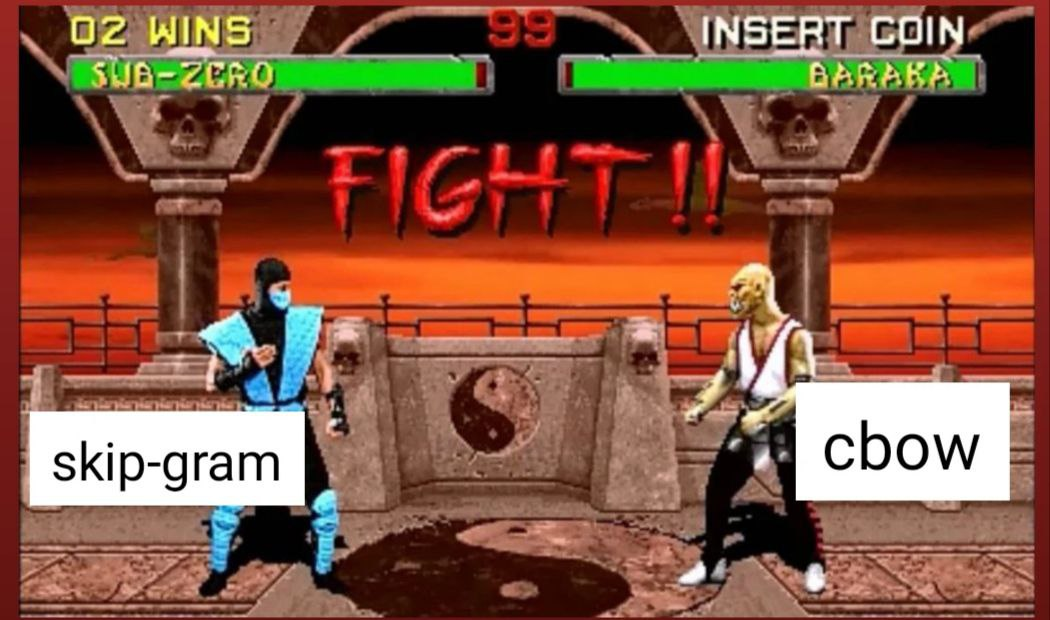

In [145]:
most_similar('гора', embeddings_cbow)

['гора',
 'склон',
 'долина',
 'озеро',
 'плато',
 'скала',
 'вдоль',
 'хребет',
 'высота',
 'лес']

In [146]:
most_similar('гора', embeddings_sg)


['гора',
 'озеро',
 'склон',
 'долина',
 'плато',
 'высота',
 'река',
 'метр',
 'север',
 'лес']

In [147]:
most_similar('город', embeddings_cbow)

['город',
 'территория',
 'деревня',
 'округ',
 'центр',
 'столица',
 'образовать',
 'улица',
 'губерния',
 'граница']

In [148]:
most_similar('город', embeddings_sg)

['город',
 'территория',
 'деревня',
 'округ',
 'провинция',
 'граница',
 'присоединить',
 'ныне',
 'северный',
 'районный']

In [149]:
most_similar('президент', embeddings_cbow)

['президент',
 'съезд',
 'комитет',
 'избрать',
 'вице-президент',
 'член',
 'парламент',
 'генеральный',
 'партия',
 'председатель']

In [150]:
most_similar('президент', embeddings_sg)

['президент',
 'вице-президент',
 'руководитель',
 'директор',
 'председатель',
 'генеральный',
 'член',
 'возглавлять',
 'партия',
 'комитет']

# Вывод: очевидного победителя я не наблюдаю.

# Задание 2

In [152]:
texts = [preprocess(text) for text in wiki]

word2vec:

In [153]:
w2v = gensim.models.Word2Vec(texts)

In [154]:
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=250, 
                             min_count=20, 
                             max_vocab_size=15000,
                             ns_exponent=0.80,
                             sg=0, 
                             hs=1,
                             negative=5,
                             sample=1e-4,
                             cbow_mean=3,
                             window=4,
                             epochs=10)

fast text:

In [155]:
ft = gensim.models.FastText(texts)

In [156]:
ft = gensim.models.FastText(texts, 
                            min_n=2, 
                            max_n=11,
                            vector_size=200, 
                            min_count=20, 
                            max_vocab_size=10000,
                            ns_exponent=0.95,
                            sg=0, 
                            hs=1,
                            negative=7,
                            sample=1e-4,
                            cbow_mean=4,
                            window=4,
                            epochs=11
                           )

Сравнивать особо нет смысла, так как параметры разные, но из любопытства посмотрим, что тут происходит:

In [157]:
w2v.wv.most_similar('ходить')

[('идти', 0.36127781867980957),
 ('общаться', 0.3541227877140045),
 ('автобус', 0.3498208522796631),
 ('ехать', 0.34445253014564514),
 ('приезжать', 0.3257996439933777),
 ('сидеть', 0.3137192130088806),
 ('отправлять', 0.3039594292640686),
 ('посещать', 0.300386905670166),
 ('никто', 0.2921314239501953),
 ('поезд', 0.2889462411403656)]

In [158]:
ft.wv.most_similar('ходить')

[('находить', 0.6254013180732727),
 ('идти', 0.48775631189346313),
 ('выходить', 0.4701355993747711),
 ('попадать', 0.4656963050365448),
 ('держать', 0.4303120970726013),
 ('жить', 0.4241572618484497),
 ('собираться', 0.4230268895626068),
 ('проходить', 0.41606083512306213),
 ('убивать', 0.4060570001602173),
 ('приходиться', 0.3996012508869171)]

In [159]:
w2v.wv.most_similar('маленький')

[('большой', 0.3869962692260742),
 ('малый', 0.37574249505996704),
 ('намного', 0.37259411811828613),
 ('выше', 0.3609200119972229),
 ('больший', 0.3580716550350189),
 ('вырасти', 0.3191292881965637),
 ('небольшой', 0.307831346988678),
 ('более', 0.3005596101284027),
 ('ниже', 0.29779624938964844),
 ('длинный', 0.2877942621707916)]

In [160]:
ft.wv.most_similar('маленький')

[('большой', 0.5571520924568176),
 ('мало', 0.5165091753005981),
 ('небольшой', 0.4639541208744049),
 ('малый', 0.45974716544151306),
 ('больший', 0.4563716650009155),
 ('значительно', 0.41902634501457214),
 ('сильно', 0.41716212034225464),
 ('длинный', 0.41137051582336426),
 ('очень', 0.3912656009197235),
 ('похожий', 0.3767889142036438)]